In [ ]:
import os
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
import numpy as np

import torch
from torch import tensor
from utils.load_folktables import prepare_folktables_multattr
from humancompatible.train.fairness.constraints.constraint_fns import *
from fairret.statistic import *
from utils.network import SimpleNet

This notebook presents some useful plots based on the performance of the trained models.

### **Preparation**

**Load the Folktables dataset for the selected state and prepare it for usage**

In [ ]:
TASK = "income"
STATE = "VA"

In [ ]:
sens_cols=[
    "MAR",
    # "SEX",
    # 'RAC1P',
    ]

(
    X_train,
    y_train,
    group_ind_train,
    group_onehot_train,
    sep_group_ind_train,
    X_test,
    y_test,
    group_ind_test,
    group_onehot_test,
    sep_group_ind_test,
    group_order
) = prepare_folktables_multattr(
    TASK,
    state=STATE.upper(),
    random_state=42,
    onehot=False,
    download=True,
    sens_cols=sens_cols,
    binarize=[None],
    stratify=False,
)

In [ ]:
group_onehot_train.sum(axis=0)

tensor([11014., 20854.,  3603.,   707.,   737.])

In [ ]:
group_codes = {
    "MAR": {0: "OTHER", 1: "Mar", 2: "Wid", 3: "Div", 4: "Sep", 5:"Nev"},
    "SEX": {0: "OTHER", 1: "M", 2: "F"},
    "RAC1P": {0: "OTHER", 1: "W", 2: "B", 3: "AI", 4: "AN", 5: "AIAN", 6: "A", 7: "PA", 8: "OT", 9: "TW"}
}
groups_sep = [[int(g) for g in gr.split('_')] for gr in group_order]
group_names = [
    [
        group_codes[sens_cols[i]][c]
        for i, c in enumerate(gc)
    ]
    for gc in groups_sep]
group_names = ['_'.join(g) for g in group_names]
group_names

['Mar', 'Wid', 'Div', 'Sep', 'Nev']

In [ ]:
device = "cuda" if torch.cuda.is_available() and False else "cpu"

In [ ]:
X_train_tensor = tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = tensor(y_train, dtype=torch.float, device=device)

X_test_tensor = tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = tensor(y_test, dtype=torch.float, device=device)

In [ ]:
len(X_test_tensor) 

9229

**Load saved models**

In [ ]:
from itertools import product

constraints = {
    # "loss_equality": 0.005,
    # "unconstrained": 0.005,
    # "unconstrained": 0.03,
    "abs_diff_pr": 0.05,
}

dict_alg_names = {
    "StochasticGhost": "Ghost",
    "SSLALM": "SSLALM",
    "SSG": "SSw",
    # "SGD": "SGD",
    "Adam": "Adam",
    "fairret": "SGD-Fairret",
    "TorchSSLALM": "SSLALM",
    "TorchSSG": "SSG"
}

DATASET = TASK + "_" + STATE
loaded_models = []

for constr, cb in constraints.items():
    DIRECTORY_PATH = (
        "./utils/saved_models/" + DATASET + "/" + constr + "/" + ((f"{cb:.0E}" + "/") if cb is not None else '')
    )
    FILE_EXT = ".pt"

    directory_path = DIRECTORY_PATH
    print(f"Looking for models in: {directory_path}")
    try:
        file_list = os.listdir(directory_path)
    except FileNotFoundError:
        print("Not found")
        continue
    model_files = [file for file in file_list if file.endswith(FILE_EXT)]
    for model_file in model_files:
        if model_file.split("_")[0] not in dict_alg_names.keys():
            continue
        model_name = model_file
        model = SimpleNet(X_test.shape[1], 1, torch.float32).to(device)
        print(model_file)
        try:
            model.load_state_dict(
                torch.load(
                    directory_path + model_name, weights_only=True, map_location=device
                )
            )
        except:
            continue
        loaded_models.append((model_file, model))


Looking for models in: ./utils/saved_models/income_VA/abs_diff_pr/5E-02/
Adam_0.05_trial0.pt
Adam_0.05_trial1.pt
Adam_0.05_trial2.pt
Adam_0.05_trial3.pt
Adam_0.05_trial4.pt
TorchSSG_0.05_trial0.pt
TorchSSG_0.05_trial1.pt
TorchSSG_0.05_trial2.pt
TorchSSG_0.05_trial3.pt
TorchSSG_0.05_trial4.pt
TorchSSLALM_0.05_trial0.pt
TorchSSLALM_0.05_trial1.pt
TorchSSLALM_0.05_trial2.pt
TorchSSLALM_0.05_trial3.pt
TorchSSLALM_0.05_trial4.pt


### **Evaluation**

**Calculate test set statistics for the models - AUC, constraint satisfaction, loss, etc.. and aggregate per algorithm:**

In [ ]:
from utils.stats import make_pairwise_constraint_stats_table, aggregate_model_stats_table, make_groupwise_stats_table

**Train set**:

In [ ]:
loaded_models.sort(key=lambda x: x[0])

In [ ]:
full_data_stats = make_groupwise_stats_table(
    X_train_tensor,
    y_train_tensor,
    loaded_models
    ).drop('Model',axis=1).groupby('Algorithm').agg('mean')

groupwise_stats = []

for group_ind in group_ind_train:
    groupwise_stats.append(
        make_groupwise_stats_table(
            X_train_tensor[group_ind],
            y_train_tensor[group_ind],
            loaded_models
        ).drop('Model',axis=1).groupby('Algorithm').agg('mean')
    )

In [ ]:
groupwise_dev = []

for group_stats in groupwise_stats:
    diff = group_stats - full_data_stats
    diff = diff.add_suffix('_dev')
    diff['Sp'] = abs(diff['tpr_dev']) + abs(diff['fpr_dev'])
    diff['Ind'] = abs(diff['ppv_dev']) + abs(diff['fomr_dev'])
    diff['Sf'] = abs(diff['pr_dev'])
    diff['Ina'] = 1 - group_stats['acc']
    groupwise_dev.append(diff)


In [ ]:
import pandas as pd
stats = pd.concat(groupwise_stats, keys=group_names, names=['group'])
stats

acc       auc       fpr tpr_fairret       tpr  \
group Algorithm                                                              
Mar   Adam_0.05         0.766865  0.847796   0.24199    0.704988  0.774028   
      TorchSSG_0.05     0.678652  0.828342  0.096011    0.485124  0.496357   
      TorchSSLALM_0.05  0.690745  0.818447  0.127021    0.499286  0.543321   
Wid   Adam_0.05         0.854274  0.940045  0.089908     0.70464  0.773422   
      TorchSSG_0.05     0.757938  0.840503  0.067431    0.497907  0.504983   
      TorchSSLALM_0.05  0.748711  0.803796  0.091743    0.490302  0.517608   
Div   Adam_0.05         0.774521  0.858732  0.211232    0.689075  0.758214   
      TorchSSG_0.05     0.714516  0.819612  0.098908    0.486335  0.500952   
      TorchSSLALM_0.05  0.716125  0.799157  0.136557    0.498739    0.5475   
Sep   Adam_0.05         0.892786  0.960926    0.0869    0.750018  0.855422   
      TorchSSG_0.05     0.782744  0.862429  0.063755    0.484225  0.500402   
      TorchSSLALM_0.05  0.757284  0.824460  0.082969    0.476932  0.463454   
Nev   Adam_0.05         0.864754  0.913599   0.07921    0.608867  0.658829   
      TorchSSG_0.05     0.839005  0.848803  0.065858    0.483052  0.489389   
      TorchSSLALM_0.05  0.822244  0.840620  0.074382    0.477298   0.44236   

                             ppv      fomr        pr pr_fairret  
group Algorithm                                                  
Mar   Adam_0.05         0.762383  0.229369  0.536099   0.523763  
      TorchSSG_0.05     0.839937  0.356591   0.31732     0.4165  
      TorchSSLALM_0.05  0.810807  0.343198   0.35715   0.423511  
Wid   Adam_0.05         0.898162   0.19664  0.369064   0.396713  
      TorchSSG_0.05     0.883404  0.346351  0.246133   0.388996  
      TorchSSLALM_0.05  0.849753  0.346815  0.265672   0.380394  
Div   Adam_0.05         0.782851  0.234081  0.466278      0.469  
      TorchSSG_0.05     0.836689  0.355856  0.286372   0.405305  
      TorchSSLALM_0.05  0.800773  0.343737  0.328171   0.413254  
Sep   Adam_0.05         0.908145   0.13592  0.357567   0.374544  
      TorchSSG_0.05     0.887951  0.347268  0.217539   0.370434  
      TorchSSLALM_0.05  0.847883  0.368883  0.216973   0.364005  
Nev   Adam_0.05         0.893082   0.26992  0.203196   0.224092  
      TorchSSG_0.05     0.883054  0.352184  0.156455   0.362158  
      TorchSSLALM_0.05  0.857179  0.375608  0.153096   0.340639

In [ ]:
import pandas as pd
con = pd.concat(groupwise_dev, keys=group_names, names=['group'])
con

acc_dev   auc_dev   fpr_dev tpr_fairret_dev  \
group Algorithm                                                        
Mar   Adam_0.05        -0.034110 -0.038073    0.0772        0.015023   
      TorchSSG_0.05    -0.054920 -0.010030  0.013592       -0.000048   
      TorchSSLALM_0.05 -0.044143 -0.012590  0.022738        0.003785   
Wid   Adam_0.05         0.053299  0.054176 -0.074882        0.014676   
      TorchSSG_0.05     0.024366  0.002131 -0.014988        0.012735   
      TorchSSLALM_0.05  0.013823 -0.027241  -0.01254       -0.005199   
Div   Adam_0.05        -0.026454 -0.027137  0.046442       -0.000889   
      TorchSSG_0.05    -0.019056 -0.018760  0.016489        0.001163   
      TorchSSLALM_0.05 -0.018763 -0.031880  0.032274        0.003238   
Sep   Adam_0.05         0.091811  0.075057 -0.077891        0.060054   
      TorchSSG_0.05     0.049172  0.024057 -0.018664       -0.000947   
      TorchSSLALM_0.05  0.022396 -0.006577 -0.021314       -0.018568   
Nev   Adam_0.05         0.063779  0.027729  -0.08558       -0.081097   
      TorchSSG_0.05     0.105433  0.010430 -0.016561       -0.002121   
      TorchSSLALM_0.05  0.087356  0.009583 -0.029901       -0.018203   

                         tpr_dev   ppv_dev  fomr_dev    pr_dev pr_fairret_dev  \
group Algorithm                                                                 
Mar   Adam_0.05         0.017246 -0.059254   0.00417  0.112894       0.100149   
      TorchSSG_0.05     0.000316 -0.019017  0.003132  0.054349       0.018737   
      TorchSSLALM_0.05   0.01604 -0.024519 -0.002006  0.068221       0.027728   
Wid   Adam_0.05         0.016639  0.076525 -0.028559 -0.054141        -0.0269   
      TorchSSG_0.05     0.008943  0.024449 -0.007109 -0.016839      -0.008767   
      TorchSSLALM_0.05 -0.009673  0.014427  0.001611 -0.023257       -0.01539   
Div   Adam_0.05         0.001431 -0.038785  0.008882  0.043073       0.045386   
      TorchSSG_0.05     0.004912 -0.022265  0.002397  0.023401       0.007543   
      TorchSSLALM_0.05  0.020219 -0.034553 -0.001467  0.039242       0.017471   
Sep   Adam_0.05         0.098639  0.086508 -0.089279 -0.065637       -0.04907   
      TorchSSG_0.05     0.004361  0.028997 -0.006192 -0.045433      -0.027328   
      TorchSSLALM_0.05 -0.063827  0.012558  0.023679 -0.071955      -0.031779   
Nev   Adam_0.05        -0.097954  0.071446  0.044721 -0.220009      -0.199521   
      TorchSSG_0.05    -0.006652    0.0241 -0.001275 -0.106516      -0.035604   
      TorchSSLALM_0.05 -0.084921  0.021854  0.030405 -0.135833      -0.055145   

                              Sp       Ind        Sf       Ina  
group Algorithm                                                 
Mar   Adam_0.05         0.094446  0.063423  0.112894  0.233135  
      TorchSSG_0.05     0.013908  0.022149  0.054349  0.321348  
      TorchSSLALM_0.05  0.038778  0.026525  0.068221  0.309255  
Wid   Adam_0.05         0.091521  0.105085  0.054141  0.145726  
      TorchSSG_0.05     0.023931  0.031558  0.016839  0.242062  
      TorchSSLALM_0.05  0.022213  0.016039  0.023257  0.251289  
Div   Adam_0.05         0.047874  0.047667  0.043073  0.225479  
      TorchSSG_0.05     0.021401  0.024662  0.023401  0.285484  
      TorchSSLALM_0.05  0.052493   0.03602  0.039242  0.283875  
Sep   Adam_0.05         0.176529  0.175787  0.065637  0.107214  
      TorchSSG_0.05     0.023025  0.035188  0.045433  0.217256  
      TorchSSLALM_0.05  0.085141  0.036237  0.071955  0.242716  
Nev   Adam_0.05         0.183535  0.116167  0.220009  0.135246  
      TorchSSG_0.05     0.023213  0.025375  0.106516  0.160995  
      TorchSSLALM_0.05  0.114822  0.052259  0.135833  0.177756

In [ ]:
from itertools import combinations
import pandas as pd

bin_dfs = []

for group_idx_1, group_idx_2 in list(combinations(group_ind_train, 2)):
    X_train_1, y_train_1 = X_train_tensor[group_idx_1], y_train_tensor[group_idx_1]
    X_train_2, y_train_2 = X_train_tensor[group_idx_2], y_train_tensor[group_idx_2]
    table = make_pairwise_constraint_stats_table(
        X_train_1, y_train_1, X_train_2, y_train_2, loaded_models
    )
    table.index = table.Algorithm.apply(lambda x: dict_alg_names[x.split("_")[0]])
    table.drop("Algorithm", axis=1, inplace=True)
    bin_dfs.append(table)
    
df_train = pd.concat(bin_dfs, axis=0, keys=range(len(bin_dfs)), names=["constraint"])

In [ ]:
train_df = aggregate_model_stats_table(
    df_train, "mean", agg_cols=["constraint", "Algorithm"]
)
train_df_std = aggregate_model_stats_table(
    df_train, ["mean", "std"], agg_cols=["constraint", "Algorithm"]
)
train_df_std.drop("Algname", axis=1, inplace=True)

In [ ]:
train_df

AUC_M       Ind        Sp       Ina        Sf  \
constraint Algorithm                                                     
0          Adam       0.893921  0.167035  0.184368  0.230151  0.184764   
           SSG        0.834422  0.071187  0.056364  0.318642  0.165326   
           SSLALM     0.811122  0.091478  0.060991  0.307276   0.16919   
1          Adam       0.853264   0.06982  0.046572  0.232007  0.097736   
           SSG        0.823977  0.030948   0.02717  0.316065  0.129868   
           SSLALM     0.808802  0.028979  0.020987  0.305516  0.141311   
2          Adam       0.904361  0.178531  0.236484  0.229006  0.234684   
           SSG        0.845385  0.099782  0.046928  0.317935  0.236617   
           SSLALM     0.821454  0.140177  0.123919  0.307073  0.240408   
3          Adam       0.880697  0.332903   0.27798  0.199303  0.281289   
           SSG        0.838572  0.160865  0.056414  0.265928  0.470098   
           SSLALM     0.829534  0.204054    0.1536  0.263807  0.471661   
4          Adam       0.899389  0.097214  0.148498  0.211935  0.166117   
           SSG        0.830057  0.040239   0.04739  0.278111  0.080341   
           SSLALM     0.801477  0.062499  0.074706  0.278341  0.063517   
5          Adam       0.950486  0.014976  0.097372  0.126870  0.090209   
           SSG        0.851466  0.028594  0.037777  0.229917  0.071291   
           SSLALM     0.814128  0.048699  0.065913  0.247091  0.071217   
6          Adam       0.926822  0.165868  0.135116  0.135903  0.217959   
           SSG        0.844653  0.089678  0.062307  0.166079  0.304772   
           SSLALM     0.822208  0.112576  0.092609  0.182367  0.302471   
7          Adam       0.909829  0.108711   0.22154  0.206079  0.216037   
           SSG        0.841020  0.068834  0.047206  0.274292  0.110377   
           SSLALM     0.811809  0.111198  0.137634  0.277123  0.099097   
8          Adam       0.886165  0.263082  0.231408  0.157488  0.183553   
           SSG        0.834207  0.129917  0.063422  0.191681  0.340231   
           SSLALM     0.819889  0.175075  0.167315  0.203913   0.33035   
9          Adam       0.937262  0.154371   0.20494  0.133555  0.161057   
           SSG        0.855616  0.061083  0.025047  0.164389  0.233481   
           SSLALM     0.832540  0.063877  0.032537  0.181674  0.231253   

                            Wd  |Loss_0 - Loss_1| |TPR_0 - TPR_1|  acc_diff  \
constraint Algorithm                                                          
0          Adam       0.024777           0.168089        0.032286  0.087409   
           SSG        0.001926           0.068741        0.027784  0.079286   
           SSLALM     0.002988           0.042991        0.025713  0.057966   
1          Adam       0.004280           0.024018        0.015814  0.007656   
           SSG        0.000339           0.026191        0.019113  0.035864   
           SSLALM     0.000257           0.016797         0.01145  0.025380   
2          Adam       0.032694           0.222663        0.081393  0.125922   
           SSG        0.002942           0.089289        0.014672  0.104092   
           SSLALM     0.004095           0.070718        0.079867  0.066539   
3          Adam       0.125699           0.193827          0.1152  0.097889   
           SSG        0.004718           0.118988        0.026261  0.160353   
           SSLALM     0.007702           0.129795        0.100961  0.131499   
4          Adam       0.008696           0.144071        0.027173  0.079753   
           SSG        0.000879           0.042550        0.015914  0.043422   
           SSLALM     0.001770           0.026194        0.029892  0.032586   
5          Adam       0.001429           0.054574           0.082  0.038512   
           SSG        0.000812           0.020548        0.024078  0.024806   
           SSLALM     0.000744           0.027727        0.054154  0.010663   
6          Adam       0.035453           0.025738        0.114593  0.012560 

**Plots:**

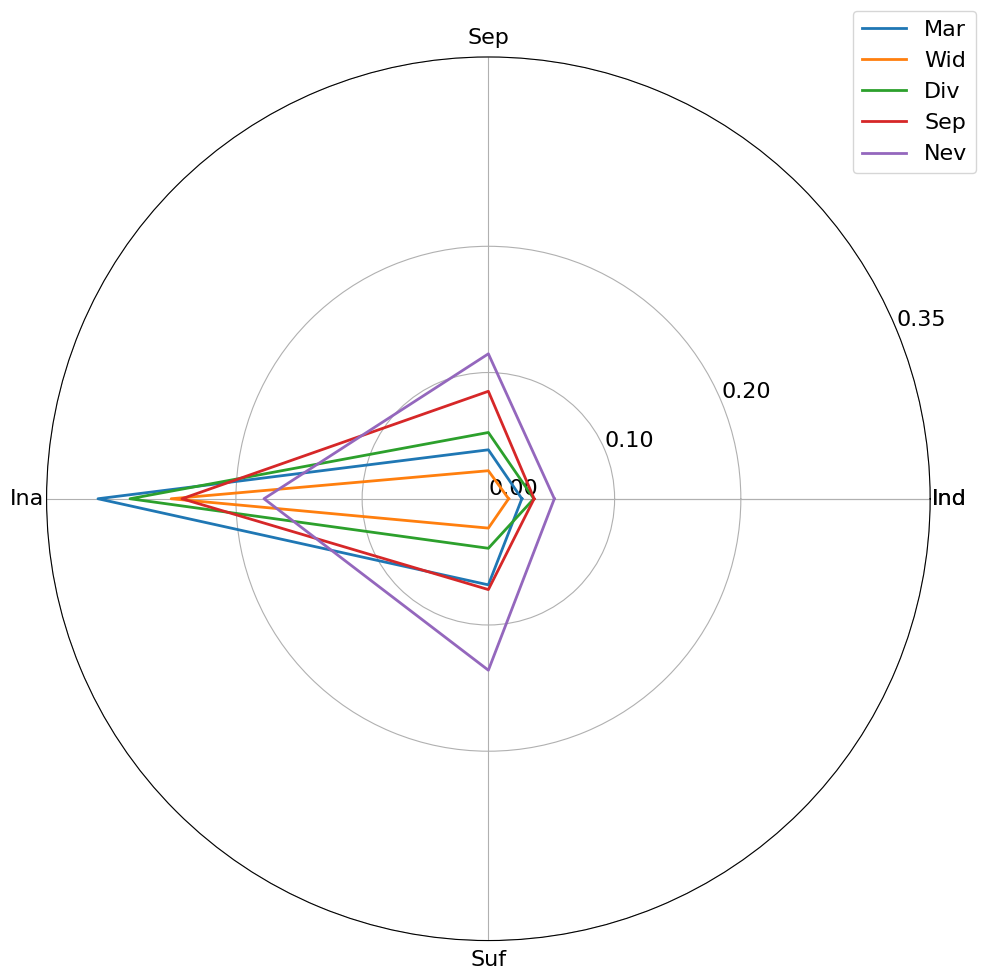

In [ ]:
from utils.plotting import spider_line
cr = con.reset_index()
cr_alg = cr[cr['Algorithm'] == 'TorchSSLALM_0.05']
cr_alg.index = cr_alg.group

f = spider_line(cr_alg, yticks=[0,0.1,0.2,0.35])

**Distribution of predictions by group:**

In [ ]:
predictions_by_alg = {alg: {} for alg in set([model_name.split("_")[0] for model_name, _ in loaded_models])}


for i, group in enumerate(group_ind_test):
    for model_name, model in loaded_models:
        alg = model_name.split("_")[0]

        preds = torch.nn.functional.sigmoid(model(X_test_tensor[group])).detach().numpy().squeeze()
        try:
            predictions_by_alg[alg][i].append(preds)
        except:
            predictions_by_alg[alg][i] = [preds]

for alg in predictions_by_alg.keys():
    for i in predictions_by_alg[alg].keys():
        predictions_by_alg[alg][i] = np.concatenate(predictions_by_alg[alg][i])

In [ ]:
pred_dfs = {}

for alg, pred_dict in predictions_by_alg.items():
    preds = []
    groups = []
    for group, group_preds in pred_dict.items():
        preds.extend(group_preds)
        groups.extend([group]*len(group_preds))
    
    pred_dfs[alg] = (
        pd.DataFrame({'pred': preds, 'group': groups})
    )

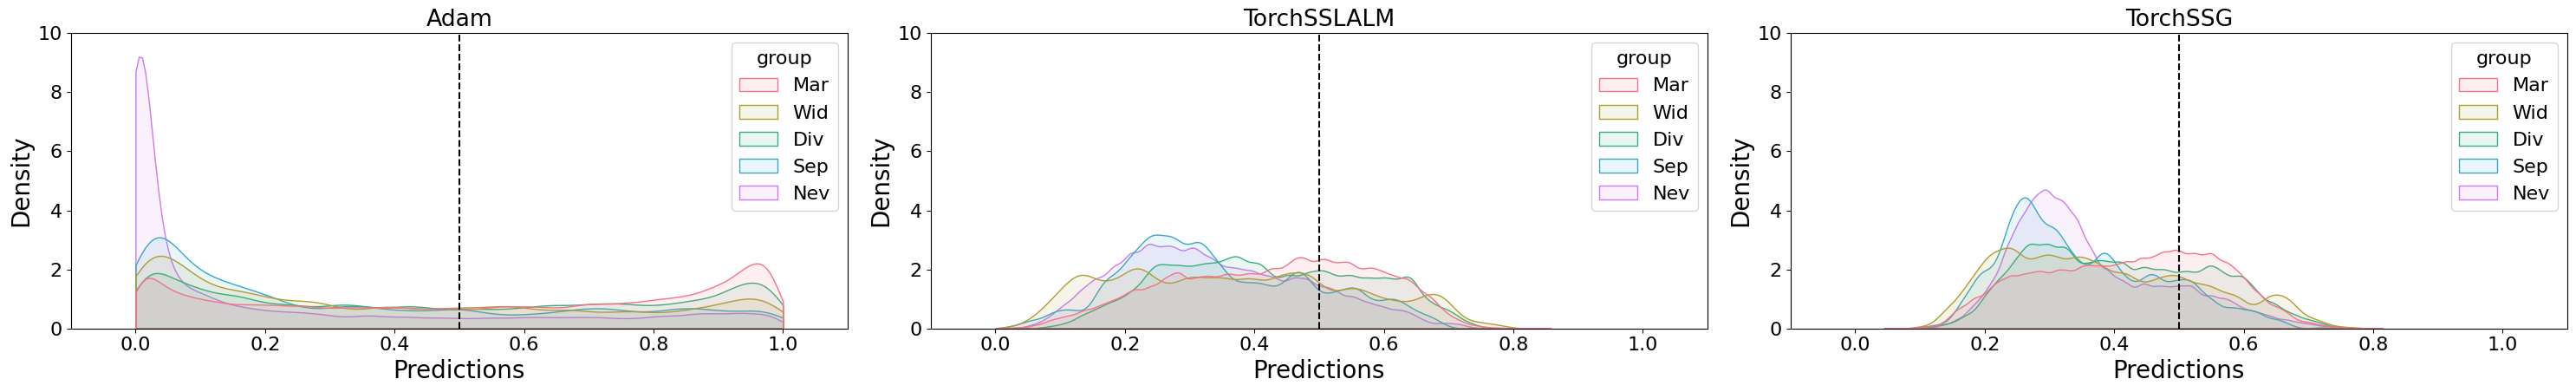

In [ ]:
import seaborn as sns

fig, axs = plt.subplots(nrows=1, ncols=3)

for i, (alg, predictions) in enumerate(pred_dfs.items()):
    ax = axs[i]
    predictions.group = predictions.group.apply(lambda x: group_names[x])
    sns.kdeplot(
        predictions,
        x='pred',
        hue='group',
        palette=sns.color_palette("husl", 5),
        fill=True,
        alpha=0.1,
        bw_adjust=0.4,
        ax=ax,
        clip=[0,1],
        common_norm=False)
    ax.vlines(0.5,0.,10, ls='--',color='black')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(0, 10)
    ax.set_xlabel("Predictions", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    ax.set_title(alg)

fig.set_figwidth(30)
fig.tight_layout()

### **Model plots**

**We choose one model per algorithm to make some useful plots**

For now, choose the model with the highest mean AUC:

In [ ]:
df_train.index.get_level_values('Algorithm').unique()

Index(['Adam', 'SSG', 'SSLALM'], dtype='object', name='Algorithm')

In [ ]:
select_by = "AUC_M"

In [ ]:
best_models = {}
algs = df_train.index.get_level_values('Algorithm').unique()
for alg in algs:
    alg_df = df_train.xs(alg, level=1).reset_index()
    best_model_name = alg_df[['Model', select_by]].groupby('Model').mean()[select_by].idxmax()
    model = [(name, model) for name, model in loaded_models if name == best_model_name][0]
    best_models[alg] = model

#### Subgroup ROC

**TPR-FPR plot**

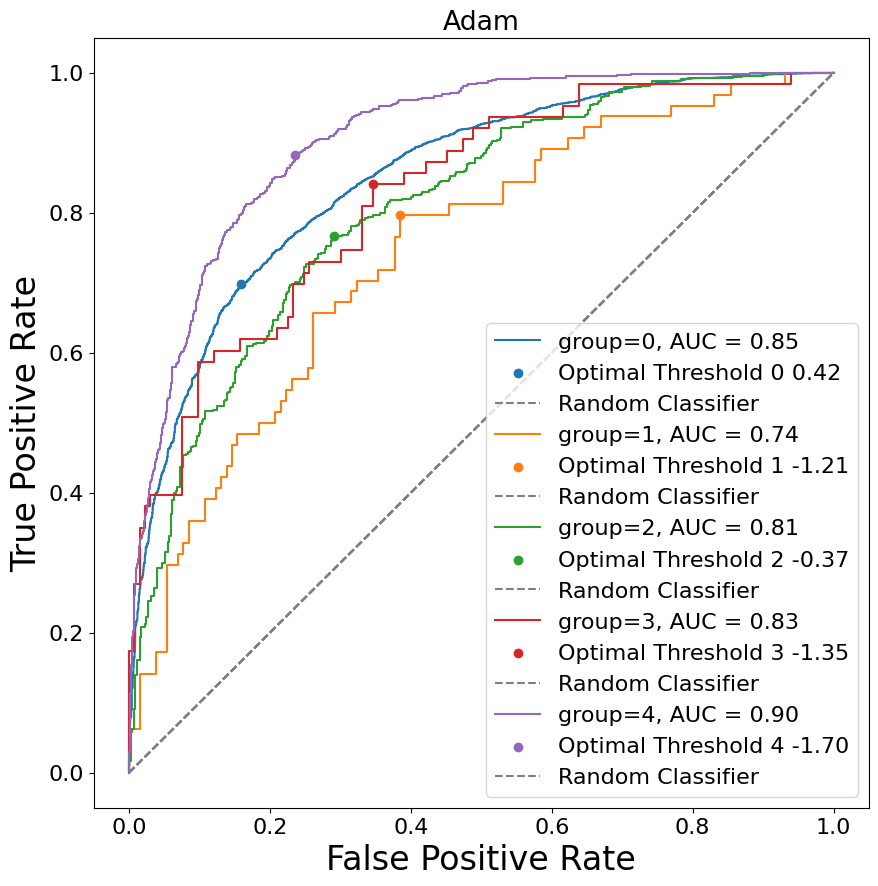

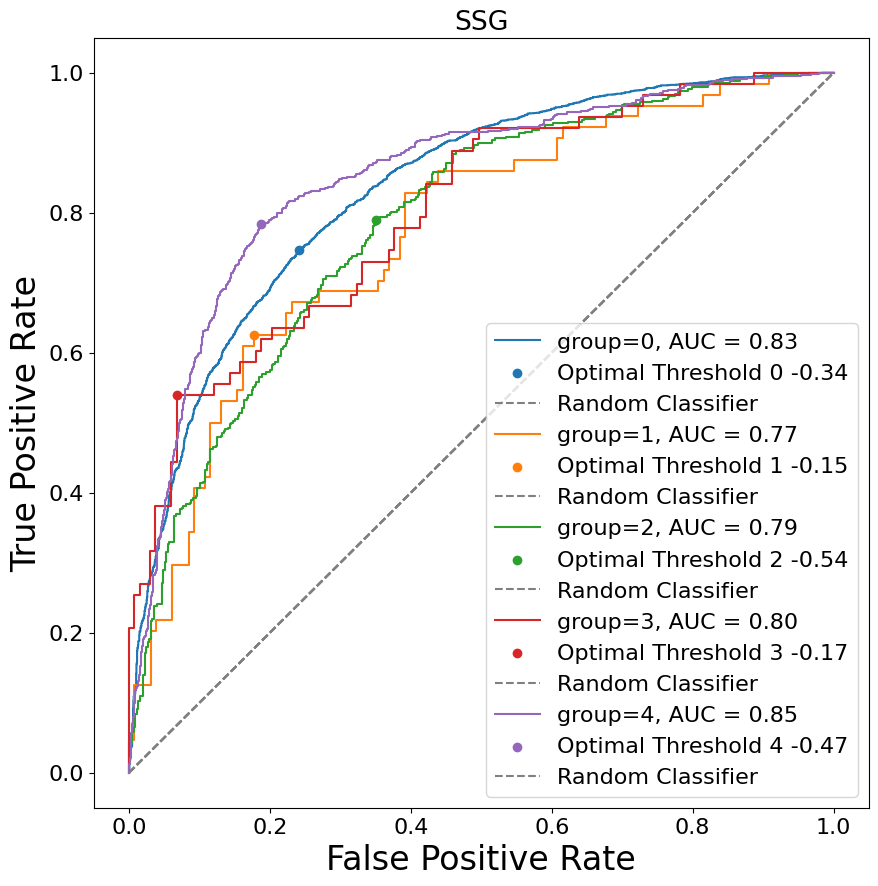

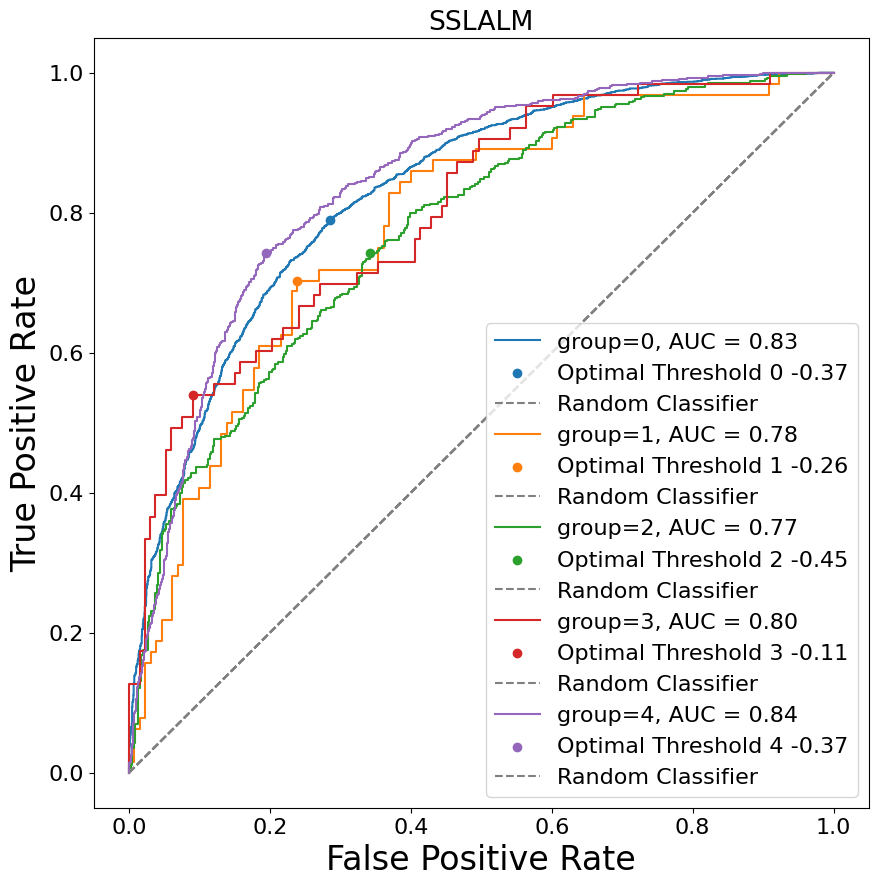

In [ ]:
# Function to generate predictions and plot ROC curve
def plot_roc_curve_pr(ax, predictions, targets, sensitive_value):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f"group={sensitive_value}, AUC = {roc_auc:.2f}")
    tpr_minus_fpr = tpr - fpr
    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tpr_minus_fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(
        fpr[optimal_threshold_index],
        tpr[optimal_threshold_index],
        # c="blue" if sensitive_value == sensitive_value_0 else "red",
        label=f"Optimal Threshold {sensitive_value} {optimal_threshold:.2f}",
    )


for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)
    ax = f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        for i,group in enumerate(group_ind_test):
            predictions = model(X_test_tensor[group])
            # Plot ROC for sensitive attribute A=0
            plot_roc_curve_pr(
                ax, predictions, y_test[group], sensitive_value=i
            )
            ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
            ax.set_xlabel("False Positive Rate", fontsize=24)
            ax.set_ylabel("True Positive Rate", fontsize=24)
            ax.legend()

**TNR-FNR plot**

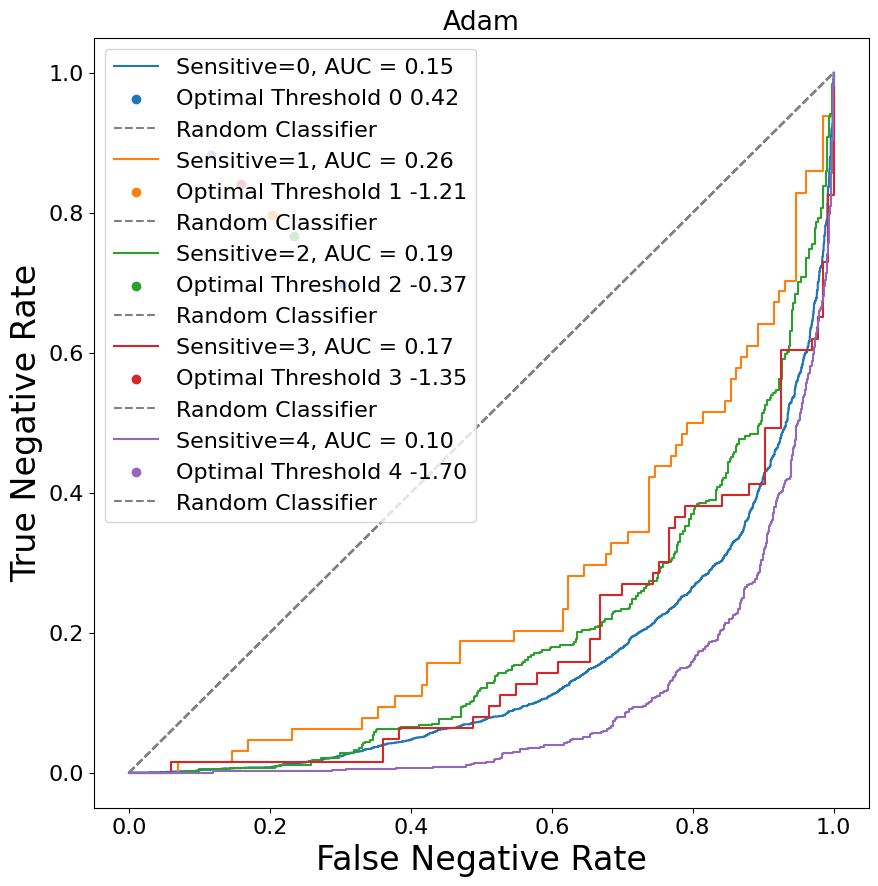

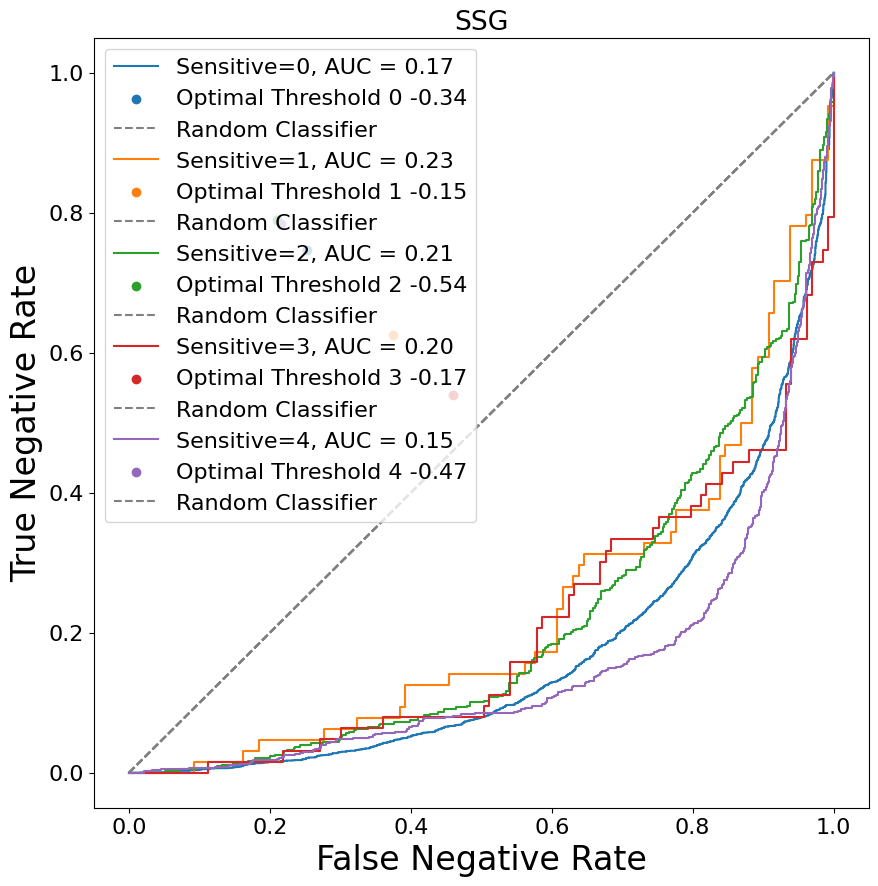

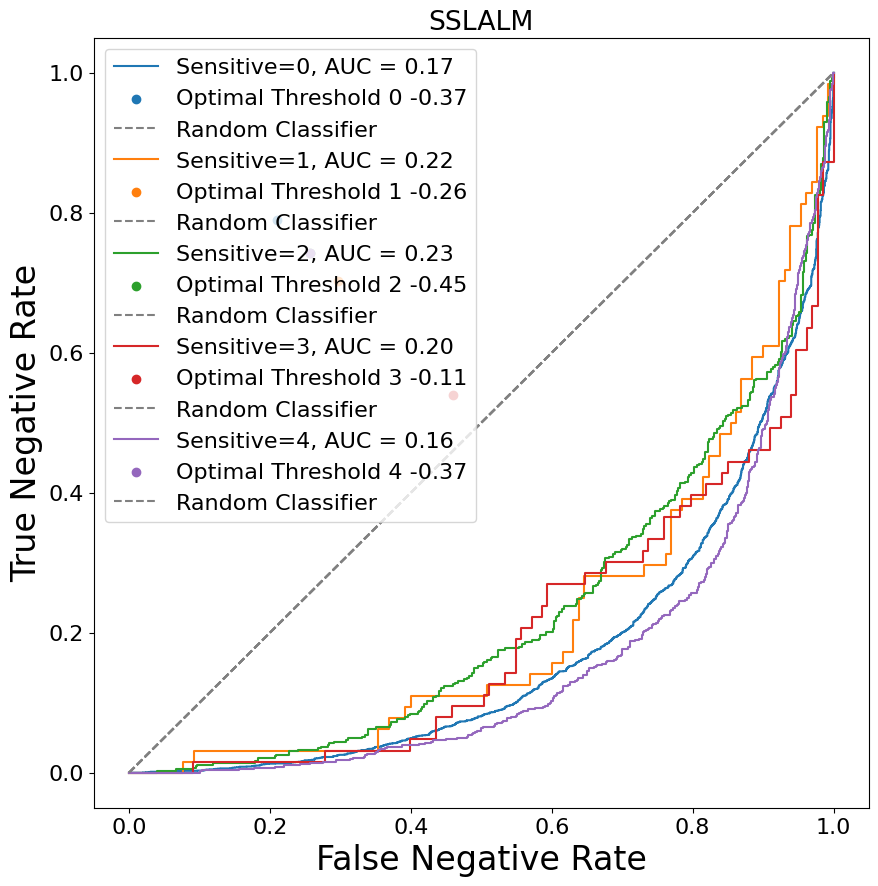

In [ ]:
# Function to generate predictions and plot ROC curve
def plot_roc_curve_nr(ax, predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    # predictions = predictions.detach().numpy()
    # targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    fnr = 1 - tpr
    tnr = 1 - fpr
    roc_auc = auc(tnr, fnr)
    # Plot ROC curve
    ax.plot(tnr, fnr, label=f"Sensitive={sensitive_value}, AUC = {roc_auc:.2f}")

    tnr_minus_fnr = tnr - fnr

    # Find the threshold that maximizes tnr - fnr difference
    optimal_threshold_index = np.argmax(tnr_minus_fnr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(
        fnr[optimal_threshold_index],
        tpr[optimal_threshold_index],
        # c="blue" if sensitive_value == sensitive_value_0 else "red",
        label=f"Optimal Threshold {sensitive_value} {optimal_threshold:.2f}",
    )


for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)
    ax = f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        for i,group in enumerate(group_ind_test):
            predictions = model(X_test_tensor[group])
            # Plot ROC for sensitive attribute A=0
            plot_roc_curve_nr(
                ax, predictions, y_test[group], sensitive_value=i
            )
            ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
            ax.set_xlabel("False Negative Rate", fontsize=24)
            ax.set_ylabel("True Negative Rate", fontsize=24)
            ax.legend()